# Exploratory data analysis for the titanic data

In [33]:
!pip install powerlaw

In [34]:
# imports here
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from typing import List, Set, Dict, Tuple, Union
import statsmodels.api as sm
from scipy import stats
import powerlaw
import re
import string

In [35]:
titanic = pd.read_csv('data/train.csv')
titanic

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [36]:
print(list(titanic.columns))

['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']


In [37]:
features = ['Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']

## Description of data columns:
1. Survived: Survived - 0 = No; 1 = Yes
2. Pclass: Ticket Class - 1 = 1st; 2 = 2nd; 3 = 3rd
3. Name: full name of passenger (including titles - Mr., Mrs., Miss, and Ms.)
4. Sex: male or female
5. Age: Age in years
6. SibSp: Number of siblings/spouses aboard the Titanic
7. Parch: Number of parents/children aboard the Titanic
8. Ticket: Ticket number
9. Fare: Passenger fare (how much paid for the cruise)
10. Cabin: Cabin number (titanic had 10 decks/floors - should be correlated with pclass somehow - my note)
11. Embarked: Port of Embarkation - C = Cherbourg, Q = Queenstown, S = Southampton


### number of rows in train: 891

## Variable Notes
pclass: A proxy for socio-economic status (SES)
1st = Upper
2nd = Middle
3rd = Lower

age: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

sibsp: The dataset defines family relations in this way...
Sibling = brother, sister, stepbrother, stepsister
Spouse = husband, wife (mistresses and fiancés were ignored)

parch: The dataset defines family relations in this way...
Parent = mother, father
Child = daughter, son, stepdaughter, stepson
Some children travelled only with a nanny, therefore parch=0 for them.

## Notes of mine to examine
1. Titanic sank at night (2:20 a.m.) which means probably a lot of passengers were in their cabins, which gives upper decks/floors advantage in surviving - strong relation to cabin and pclass.
2. Most of passengers didn't survive, usually priority in evacuation is given to elders, children and women - could be of use
3. Internet says it took 160 minutes (2 hours and 40 minutes) the Titanic to sink - if priority was given then elders, children and women were saved widely.

In [38]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [39]:
num_passengers = len(titanic)
num_survived = len(titanic[titanic['Survived'] == 1])
survived_pct = num_survived / num_passengers
print(f"Total number of passengers={num_passengers}, survived={num_survived}, survived percentage={survived_pct:.3f}")

Total number of passengers=891, survived=342, survived percentage=0.384


### General statistics on the dataset

In [40]:
titanic.describe().applymap(lambda x: f"{x:0.3f}")

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000,891.000,891.000,714.000,891.000,891.000,891.000
mean,446.000,0.384,2.309,29.699,0.523,0.382,32.204
std,257.354,0.487,0.836,14.526,1.103,0.806,49.693
min,1.000,0.000,1.000,0.420,0.000,0.000,0.000
25%,223.500,0.000,2.000,20.125,0.000,0.000,7.910
50%,446.000,0.000,3.000,28.000,0.000,0.000,14.454
75%,668.500,1.000,3.000,38.000,1.000,0.000,31.000
max,891.000,1.000,3.000,80.000,8.000,6.000,512.329


In [41]:
print("Missig values count and percent for each feature")
total = titanic.isnull().sum().sort_values(ascending=False)
percent = (titanic.isnull().sum() / titanic.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data

Missig values count and percent for each feature


,Total,Percent
Cabin,687,0.771044
Age,177,0.198653
Embarked,2,0.002245
PassengerId,0,0.000000
Survived,0,0.000000
Pclass,0,0.000000
Name,0,0.000000
Sex,0,0.000000
SibSp,0,0.000000
Parch,0,0.000000


### Issues List For the Dataset
-  Missing values in several columns: Cabin, Age and Embarked (maybe dropping Cabin column)
-  Processing string columns to numeric

# 1. Univariate Analysis: Examining each feature's statistics

### Categorical features functions

In [42]:
# Pie
def make_autopct(values):
    # custom function of printing in the pie chart
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%\n({v:d})'.format(p=pct,v=val)
    return my_autopct

def pie_chart(df: pd.DataFrame, feature: str, categories: Union[List[str], List[int]]) -> None:
    # plotting counts and percentages of each category
    counts_per_category = [df[df[feature] == category].count()[feature] for category in categories]
    # Creating plot
    fig = plt.figure(figsize =(8, 5))
    plt.pie(counts_per_category, labels=categories, autopct=make_autopct(counts_per_category), textprops={'fontsize': 14})
    plt.suptitle(feature, fontsize=18);

In [43]:
# calculate for each category count and percent (probably too much categories for pie chart)
def create_df_for_numeric_cateforical(df: pd.DataFrame, feature: str) -> pd.DataFrame:
    # using PassengerId because it has no missing values
    count_per_value = titanic[['PassengerId', feature]].groupby(feature).count()
    count_per_value.rename(columns={'PassengerId': 'Count'}, inplace=True)
    count_per_value['Percent'] = count_per_value['Count'] / count_per_value['Count'].sum()
    count_per_value.sort_values(by=['Count'], ascending=False, inplace=True)
    return count_per_value

In [44]:
def count_plot(df: pd.DataFrame, feature: str) -> None:
    # sns.countplot(data=df, y=feature)
    df[feature].value_counts(normalize=True, ascending=True).plot.barh()
    plt.title(f'Normalized Counts per Category of {feature}')
    plt.xlabel('Count')
    plt.ylabel(feature)
    plt.show();

### Continous features functions

In [45]:
# Histogram
def hist_and_kde(df: pd.DataFrame, feature: str) -> None:
    # data distribution of feature and kernel density estimation of it
    sns.histplot(df[feature].dropna(), kde=True, bins=30, stat="density", linewidth=0)
    plt.title(f'Histogram of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Density')
    plt.show();

In [46]:
def skewness_and_kurtosis(df: pd.DataFrame, feature: str) -> None:
    # Skewness as measure of symmetry (lack of symmetry)
    print(f"Skewness: {df[feature].skew():.3f}")
    # Kurtosis as a measure of whether the data are heavy-tailed or light-tailed relative to a normal distribution
    print(f"Kurtosis: {df[feature].kurt():.3f}")

In [47]:
def qqplot(df: pd.DataFrame, feature: str) -> None:
    # dropping nans for qqplot (normal distribturion)
    fig = sm.qqplot(df[feature].dropna(), line="s", fit=True)
    plt.title(f'QQ-plot of {feature}')
    plt.show();
    del fig

In [48]:
def log_log_plot(df: pd.DataFrame, feature: str) -> None:
    # log log plot for checking powerlaw distribution (similar concept to qqplot)
    fit = powerlaw.Fit(df[feature].dropna())
    fit.power_law.plot_pdf(color='r', linestyle='--')
    fit.plot_pdf(color='blue', label=feature)
    plt.title(f'Log-log of {feature}')
    plt.xlabel(f'log {feature}')
    plt.ylabel('log Count')
    plt.show();
    del fit

In [49]:
def normality_tests(df: pd.DataFrame, feature: str) -> pd.DataFrame:
    # df of p values (normal tests) for feature - null hypothesis: data is normally distributed
    statistic_shapiro, p_value_shapiro = stats.shapiro(df[feature].dropna())
    # normaltest is based on Skewness and Kurtosis
    statistic_normaltest, p_value_normaltest = stats.normaltest(df[feature], nan_policy='omit')
    statistic_chisquare, p_value_chisquare = stats.chisquare(df[feature].dropna())
    normal_tests_df = pd.DataFrame(data={'shapiro': [p_value_shapiro], 'normaltest': [p_value_normaltest], 
                                         'chisquare': [p_value_chisquare]}, index=[feature])
    return normal_tests_df

In [50]:
# Boxplot
def boxplot_and_outliers(df: pd.DataFrame, feature: str) -> None:
    # data distribution and outliers identifying using boxplot
    figure, ax = plt.subplots(figsize=(7, 6))
    sns.boxplot(x=feature, data=df).set_title(f'{feature} Boxplot', fontsize=16);
    ax.set_xlabel(feature, fontdict={'fontsize': 14})
    ax.set_ylabel('distribution', {'fontsize': 14});
    
    # boxplot outliers definition - dropping nans is required for calculating
    Q1 = np.percentile(df[feature].dropna().values, 25)  # Q1
    Q3 = np.percentile(df[feature].dropna().values, 75)  # Q3
    IQR = Q3 - Q1  # interquartile range
    lower_whisker = Q1 - 1.5 * IQR
    upper_whisker = Q3 + 1.5 * IQR
    print(f'The interquartile range: [{Q1}, {Q3}]')
    print(f'The outliers\' bounds are: lower bound={lower_whisker:.3f}, upper bound={upper_whisker:.3f}')

## Pclass

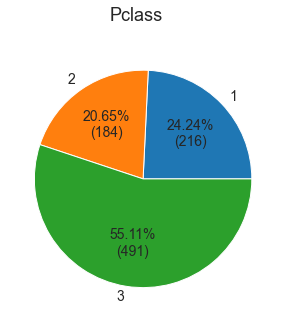

In [51]:
pie_chart(titanic, feature='Pclass', categories=[1, 2, 3])

###### Pclass explained:
As seen from a cell above we do not have any missing data on the Pclass attribute.

We can see that there is an imbalance in the partition according to Pclass and more than half of the passengers are of the 3rd (lowest "socio-economic status" class), the rest of the passengers divide pretty evenly between the first two classes (a slight difference of approximately 20 passengers - about 4%).

## Name

In [52]:
def find_honorifics(name: str) -> str:
    honorific_names = r'(?:Mrs|Mr|Ms|Miss|Master|Don|Rev|Mme|Major|Mlle|Col|Capt|Jonkheer|Countess|Dr)\.?'
    honorific = re.findall(honorific_names, name)
    if not honorific:  # empty list - no honorific found
        return 'non_honorific'
    honorific = honorific[0]  # findall returns a list - in our case list of single string
    honorific = honorific.split()[0]  # the string contains the honorific in first place if exists
    honorific = honorific.replace('.', '')
    return honorific

In [53]:
titanic['Honorifics'] = titanic['Name'].apply(lambda name: find_honorifics(name))
# checking if honorific succeeded for all passengers
all_non_honorifics = titanic[titanic['Honorifics'] == 'non_honorific']
all_non_honorifics

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Honorifics


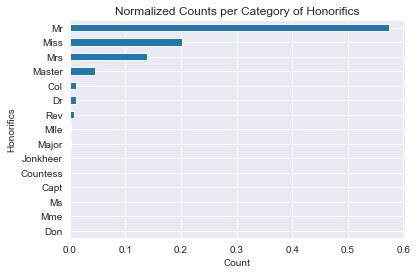

In [54]:
count_plot(titanic, 'Honorifics')

In [55]:
create_df_for_numeric_cateforical(titanic, 'Honorifics')

,Count,Percent
Honorifics,,
Mr,511,0.573513
Miss,180,0.202020
Mrs,124,0.139169
Master,40,0.044893
Col,10,0.011223
Dr,10,0.011223
Rev,6,0.006734
Major,2,0.002245
Mlle,2,0.002245


###### Name\Honorifics explained:
As seen from a cell above we do not have any missing data on the Name attribute.

From the names honorifics we conclude there are more males than females on board. In addition most people's honorifics are of regular ("common") types and not of a noble kind such as Countess. Furthermore, we see that there are some soldiers\veterans on board too, maybe their training could help them survive.

## Sex

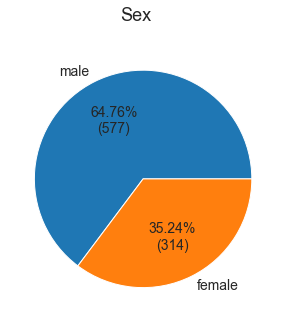

In [56]:
pie_chart(titanic, feature='Sex', categories=["male", "female"])

###### Sex explained:
As seen from a cell above we do not have any missing data on the Sex attribute.

We can see that there is an imbalance in the partition according to Sex and the data is biased to the male category, meaning most of the passengers are males.

## Age

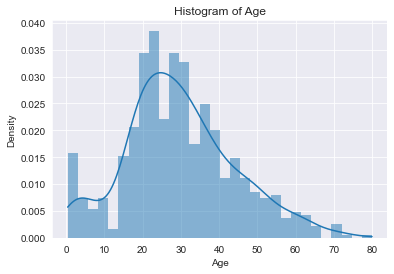

In [57]:
hist_and_kde(titanic, 'Age')

In [58]:
skewness_and_kurtosis(titanic, 'Age')

Skewness: 0.389
Kurtosis: 0.178


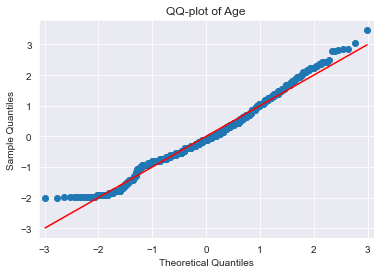

In [59]:
qqplot(titanic, 'Age')

In [60]:
age_normal_tests = normality_tests(titanic, 'Age')
age_normal_tests

,shapiro,normaltest,chisquare
Age,7.322166e-08,0.000117,0.0


The interquartile range: [20.125, 38.0]
The outliers' bounds are: lower bound=-6.688, upper bound=64.812


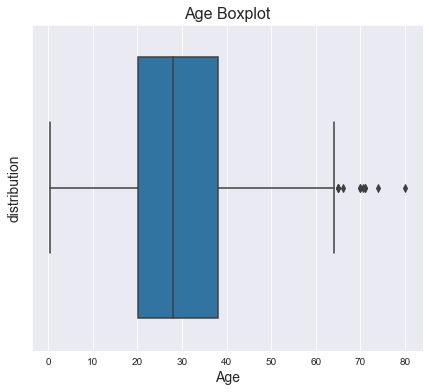

In [61]:
boxplot_and_outliers(titanic, 'Age')

In [62]:
titanic['Age'].describe()  # describe knows how to handle nans

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

###### Age explained:
As seen from a cell above we have about 20% of missing data on the Age attribute.

From the histogram it's hard to conclude that the distribution is a normal distribution (statistical tests will be done - maybe after imputing will improve), and from the skewnees value we get not so large positive skew, which means the data is skewed to the right by some amount (we have some "outliers" of old passengers). Kurtosis' small positive number indicates the peak of the frequency is slightly higher than that of a normal distribution, which indicates on having a (right) heavy tail, or outliers.

We define outliers as people with Age higher than the upper whisker bound (upper bound=64.812), and lower than the lower whisker (lower bound=-6.688) which isn't physibily so we won't have any in the lower bound since Age is non-negative. From the boxplot we can see that there aren’t any outliers in the lower side of Age (as expected), and in the upper side of Age there are some outliers. The histogram shows that the majority of people is in the Age range of 20.125-38.0 (our whiskers range).
It seems that the Age distribution is quite symmetrical (given the lower bound of 0), around the mean value of 29.69. However, we have more points in the right tail than the left tail (more outliers from the upper bound than from the lower bound).

In all the normality tests performed, the null hypothesis is that the data is normally distributed, and alternative hypothesis state the opposite. We get very low p-values from all of the tests performed so we cannot conclude our Age attribute is normally distributed. However, according to the histogram and the QQ-plot it seems that it could be normally distributed and if we had more data we could get higher p-values and reject the null hypothesis.

## SibSp

In [63]:
count_per_sibsp = create_df_for_numeric_cateforical(titanic, 'SibSp')
count_per_sibsp

,Count,Percent
SibSp,,
0,608,0.682379
1,209,0.234568
2,28,0.031425
4,18,0.020202
3,16,0.017957
8,7,0.007856
5,5,0.005612


The interquartile range: [0.0, 1.0]
The outliers' bounds are: lower bound=-1.500, upper bound=2.500


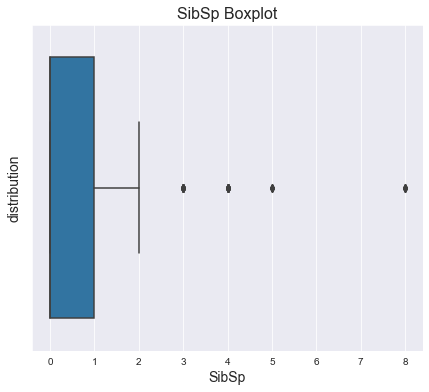

In [64]:
boxplot_and_outliers(titanic, 'SibSp')

###### SibSp explained:
As seen from a cell above we do not have any missing data on the SibSp attribute.

We conclude that most of passengers came with 0 or 1, sibling\spouse. According to boxplot outliers people with more that 2 siblings\spouses is quite unusual.

## Parch

In [65]:
count_per_parch = create_df_for_numeric_cateforical(titanic, 'Parch')
count_per_parch

,Count,Percent
Parch,,
0,678,0.760943
1,118,0.132435
2,80,0.089787
3,5,0.005612
5,5,0.005612
4,4,0.004489
6,1,0.001122


The interquartile range: [0.0, 0.0]
The outliers' bounds are: lower bound=0.000, upper bound=0.000


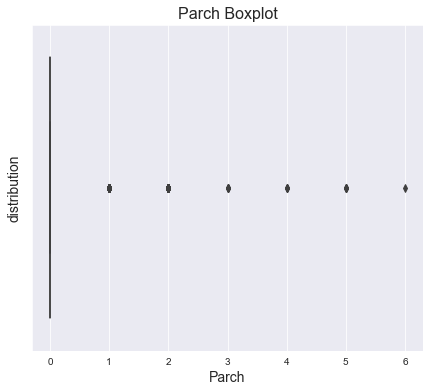

In [66]:
boxplot_and_outliers(titanic, 'Parch')

###### Parch explained:
As seen from a cell above we do not have any missing data on the Parch attribute.

We conclude most of passengers didn't travel with parents or children which fits the Age distribution (most passengers are adults).

## Ticket

In [67]:
# come back later

## Fare

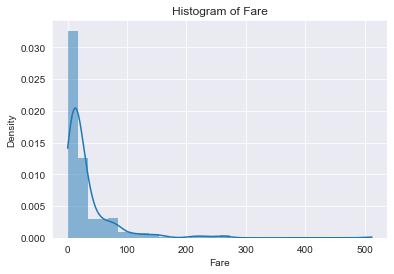

In [68]:
hist_and_kde(titanic, 'Fare')

Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit


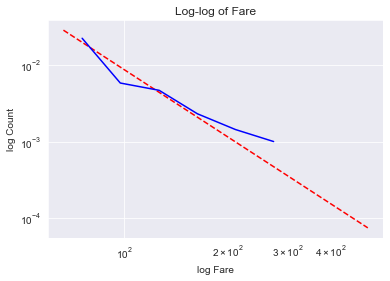

In [69]:
log_log_plot(titanic, 'Fare')

The interquartile range: [7.9104, 31.0]
The outliers' bounds are: lower bound=-26.724, upper bound=65.634


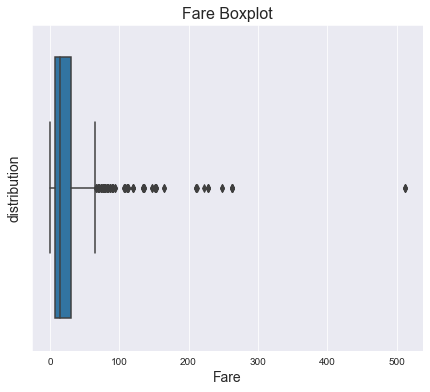

In [70]:
boxplot_and_outliers(titanic, 'Fare')

In [71]:
count_per_fare = create_df_for_numeric_cateforical(titanic, 'Fare')
count_per_fare

,Count,Percent
Fare,,
8.0500,43,0.048260
13.0000,42,0.047138
7.8958,38,0.042649
7.7500,34,0.038159
26.0000,31,0.034792
...,...,...
8.1125,1,0.001122
8.1375,1,0.001122
17.4000,1,0.001122


In [72]:
titanic['Fare'].describe()  # describe knows how to handle nans

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

###### Fare explained:
As seen from a cell above we do not have any missing data on the Fare attribute.

## Cabin

In [73]:
# come back later
cabins = titanic['Cabin'].astype(str)
cabin_char = [cab[0] for cab in cabins]  # when NaN then char would be 'n'
titanic['CabinChar'] = cabin_char
titanic['CabinChar'].unique()

array(['n', 'C', 'E', 'G', 'D', 'A', 'B', 'F', 'T'], dtype=object)

In [74]:
count_per_cabin_char = create_df_for_numeric_cateforical(titanic, 'CabinChar')
count_per_cabin_char

,Count,Percent
CabinChar,,
n,687,0.771044
C,59,0.066218
B,47,0.052750
D,33,0.037037
E,32,0.035915
A,15,0.016835
F,13,0.014590
G,4,0.004489
T,1,0.001122


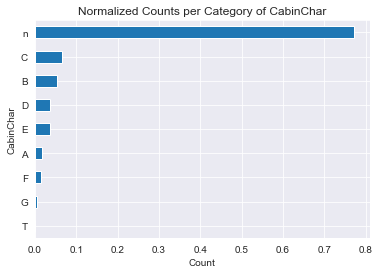

In [75]:
count_plot(titanic, 'CabinChar')

###### Cabin explained:
As seen from a cell above we do have 77% missing data on the Cabin attribute.

## Embarked

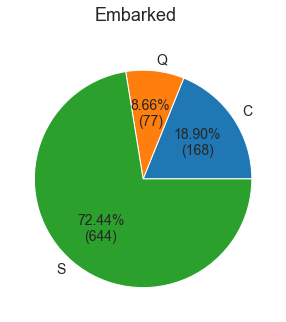

In [76]:
pie_chart(titanic, feature='Embarked', categories=['C', 'Q', 'S'])

###### Embarked explained:
As seen from a cell above we do have 2 rows of missing data on the Embarked attribute (0.2245%).

The titanic embarked from Southampton, which is where most of the passengers embarked too (72.44%). Its next stop was in Cherbourg and more passenger got into the titanic (18.9%) and at the last port being Queenstown some more passengers joined the ride (8.66%). It makes sense that the most amount of passengers embarked at the starting port of the titanic and as continuing less new passengers are embarking.

# 2. Bivariate Analysis

In [77]:
count_plot(titanic, 'CabinChar')

###### Cabin explained:
As seen from a cell above we do have 77% missing data on the Cabin attribute.

## Embarked

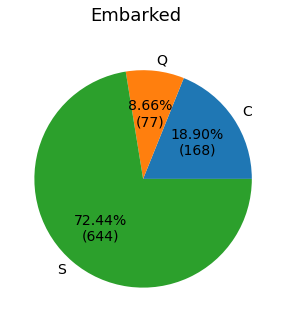

In [44]:
pie_chart(titanic, feature='Embarked', categories=['C', 'Q', 'S'])

###### Embarked explained:
As seen from a cell above we do have 2 rows of missing data on the Embarked attribute (0.2245%).

The titanic embarked from Southampton, which is where most of the passengers embarked too (72.44%). Its next stop was in Cherbourg and more passenger got into the titanic (18.9%) and at the last port being Queenstown some more passengers joined the ride (8.66%). It makes sense that the most amount of passengers embarked at the starting port of the titanic and as continuing less new passengers are embarking.

# 2. Bivariate Analysis

#  Examining each feature correlation to Survived target variable